In [16]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)
%load_ext jupyternotify

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

pandas==1.2.3
seaborn==0.10.1
numpy==1.16.6
matplotlib==3.2.2


In [3]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [74]:
from datetime import date
import nsepy as nse
import datetime as dt


data = nse.get_history(symbol='HDFC', start=dt.date(2021,1,4), end=date.today())
data = pd.DataFrame(data)

In [75]:
df = data
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2021-04-30,HDFC,EQ,2538.85,2503.1,2525.00,2411.1,2433.25,2420.1,2445.94,6024595,1.473581e+15,224454,3839105,0.6372
2021-05-03,HDFC,EQ,2420.10,2365.0,2432.95,2365.0,2423.80,2418.5,2401.40,2984938,7.168043e+14,144750,1437363,0.4815
2021-05-04,HDFC,EQ,2418.50,2420.0,2435.00,2373.6,2377.00,2377.2,2401.21,3135834,7.529787e+14,161798,1714470,0.5467
2021-05-05,HDFC,EQ,2377.20,2392.0,2403.00,2354.0,2384.25,2377.6,2376.82,3458463,8.220152e+14,126211,1961228,0.5671
2021-05-06,HDFC,EQ,2377.60,2397.3,2435.00,2382.0,2428.00,2430.1,2416.49,2401866,5.804095e+14,97225,1203739,0.5012


In [76]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
l = len(close) - 1

In [77]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [78]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, money, max_buy, max_sell):
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [102]:
%%notify


model = Model(window_size, 100, 5)
agent = Agent(model, 10000, 4, 4)
agent.fit(100,2)

iter 2. reward: -75.844000
iter 4. reward: -78.758000
iter 6. reward: -66.841000
iter 8. reward: -63.917500
iter 10. reward: -63.854000
iter 12. reward: -66.103000
iter 14. reward: -65.308000
iter 16. reward: -68.350000
iter 18. reward: 4.465500
iter 20. reward: 2.928500
iter 22. reward: 6.945000
iter 24. reward: 6.795500
iter 26. reward: 8.143500
iter 28. reward: 6.795500
iter 30. reward: 7.649000
iter 32. reward: 7.649000
iter 34. reward: 8.544500
iter 36. reward: 12.104000
iter 38. reward: 10.418500
iter 40. reward: 1.932000
iter 42. reward: 11.568000
iter 44. reward: 12.831000
iter 46. reward: 10.862500
iter 48. reward: 13.693500
iter 50. reward: 15.199000
iter 52. reward: 17.403500
iter 54. reward: 15.377500
iter 56. reward: 16.768500
iter 58. reward: 16.947000
iter 60. reward: 16.947000
iter 62. reward: 16.464500
iter 64. reward: 16.464500
iter 66. reward: 16.620500
iter 68. reward: 17.089000
iter 70. reward: 17.089000
iter 72. reward: 17.193000
iter 74. reward: 17.193000
iter 76

<IPython.core.display.Javascript object>

day 2: buy 4 units at price 10555.400000, total balance -555.400000
day 5, sell 4 units at price 11004.800000, investment 4.257536 %, total balance 10449.400000,
day 9: buy 1 units at price 2632.750000, total balance 7816.650000
day 10: buy 1 units at price 2566.500000, total balance 5250.150000
day 11, sell 2 units at price 5313.900000, investment 101.838382 %, total balance 10564.050000,
day 12: buy 1 units at price 2688.150000, total balance 7875.900000
day 17: buy 1 units at price 2425.750000, total balance 5450.150000
day 18: buy 4 units at price 9511.200000, total balance -4061.050000
day 29, sell 4 units at price 11441.800000, investment 345.813365 %, total balance 7380.750000,
day 30, sell 2 units at price 5717.300000, investment 112.685304 %, total balance 13098.050000,
day 36: buy 1 units at price 2707.750000, total balance 10390.300000
day 37: buy 1 units at price 2684.700000, total balance 7705.600000
day 38: buy 4 units at price 10157.600000, total balance -2452.000000
day

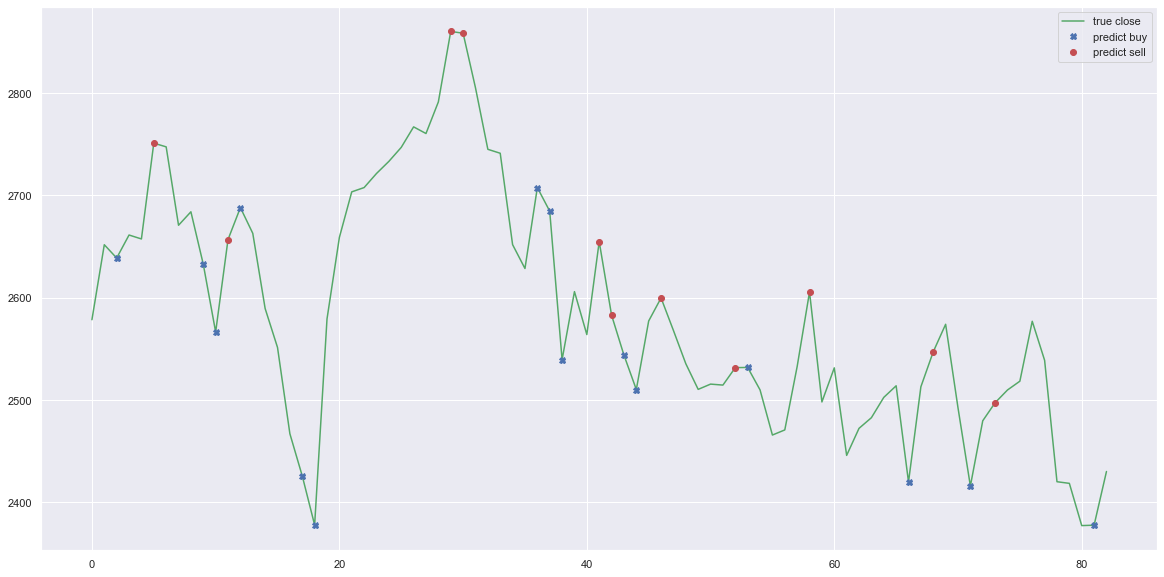

In [104]:
agent.buy()

In [92]:
a